In [1]:
import os

os.makedirs("outputs", exist_ok=True)
from dotenv import load_dotenv

load_dotenv()  # TODO: make common example prep function

from collections import OrderedDict
from datetime import datetime

import numpy as np
import torch
from loguru import logger

from earth2studio.data import DataSource, prep_data_array
from earth2studio.io import IOBackend
from earth2studio.models.dx import CorrDiffTaiwan
from earth2studio.utils.coords import map_coords, split_coords
from earth2studio.utils.time import to_time_array


def run(
    time: list[str] | list[datetime] | list[np.datetime64],
    corrdiff: CorrDiffTaiwan,
    data: DataSource,
    io: IOBackend,
    number_of_samples: int = 1,
) -> IOBackend:
    """CorrDiff infernce workflow

    Parameters
    ----------
    time : list[str] | list[datetime] | list[np.datetime64]
        List of string, datetimes or np.datetime64
    corrdiff : CorrDiffTaiwan
        CorrDiff mode
    data : DataSource
        Data source
    io : IOBackend
        IO object
    number_of_samples : int, optional
        Number of samples to generate, by default 1

    Returns
    -------
    IOBackend
        Output IO object
    """
    logger.info("Running corrdiff inference!")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Inference device: {device}")

    corrdiff = corrdiff.to(device)
    # Update the number of samples for corrdiff to generate
    corrdiff.number_of_samples = number_of_samples

    # Fetch data from data source and load onto device
    time = to_time_array(time)
    x, coords = prep_data_array(
        data(time, corrdiff.input_coords()["variable"]), device=device
    )
    x, coords = map_coords(x, coords, corrdiff.input_coords())

    logger.success(f"Fetched data from {data.__class__.__name__}")

    # Set up IO backend
    output_coords = corrdiff.output_coords(corrdiff.input_coords())
    total_coords = OrderedDict(
        {
            "time": coords["time"],
            "sample": output_coords["sample"],
            "lat": output_coords["lat"],
            "lon": output_coords["lon"],
        }
    )
    io.add_array(total_coords, output_coords["variable"])

    logger.info("Inference starting!")
    x, coords = corrdiff(x, coords)
    io.write(*split_coords(x, coords))

    logger.success("Inference complete")
    return io

In [2]:
from earth2studio.data import GFS
from earth2studio.io import ZarrBackend

# Create CorrDiff model
package = CorrDiffTaiwan.load_default_package()
corrdiff = CorrDiffTaiwan.load_model(package)

# Create the data source
data = GFS()

# Create the IO handler, store in memory
io = ZarrBackend()

In [3]:
io = run(["2023-10-04T18:00:00"], corrdiff, data, io, number_of_samples=1)


2026-01-21 18:47:31.039 | INFO     | __main__:run:49 - Running corrdiff inference!
2026-01-21 18:47:31.039 | INFO     | __main__:run:51 - Inference device: cuda


Fetching GFS data:   0%|          | 0/12 [00:00<?, ?it/s]

2026-01-21 18:47:33.765 | DEBUG    | earth2studio.data.gfs:fetch_array:379 - Fetching GFS grib file: noaa-gfs-bdp-pds/gfs.20231004/18/atmos/gfs.t18z.pgrb2.0p25.f000 337303053-570645
2026-01-21 18:47:33.768 | DEBUG    | earth2studio.data.gfs:fetch_array:379 - Fetching GFS grib file: noaa-gfs-bdp-pds/gfs.20231004/18/atmos/gfs.t18z.pgrb2.0p25.f000 264790161-556189
2026-01-21 18:47:33.770 | DEBUG    | earth2studio.data.gfs:fetch_array:379 - Fetching GFS grib file: noaa-gfs-bdp-pds/gfs.20231004/18/atmos/gfs.t18z.pgrb2.0p25.f000 412051984-953804
2026-01-21 18:47:33.771 | DEBUG    | earth2studio.data.gfs:fetch_array:379 - Fetching GFS grib file: noaa-gfs-bdp-pds/gfs.20231004/18/atmos/gfs.t18z.pgrb2.0p25.f000 258060355-819591
2026-01-21 18:47:33.774 | DEBUG    | earth2studio.data.gfs:fetch_array:379 - Fetching GFS grib file: noaa-gfs-bdp-pds/gfs.20231004/18/atmos/gfs.t18z.pgrb2.0p25.f000 331406077-849817
2026-01-21 18:47:33.776 | DEBUG    | earth2studio.data.gfs:fetch_array:379 - Fetching GFS 

Fetching GFS data: 100%|██████████| 12/12 [00:02<00:00,  4.59it/s]


2026-01-21 18:47:37.108 | SUCCESS  | __main__:run:64 - Fetched data from GFS
2026-01-21 18:47:37.124 | INFO     | __main__:run:78 - Inference starting!
2026-01-21 18:47:53.672 | SUCCESS  | __main__:run:82 - Inference complete


Text(0.5, 1.0, '10-meter Wind Speed')

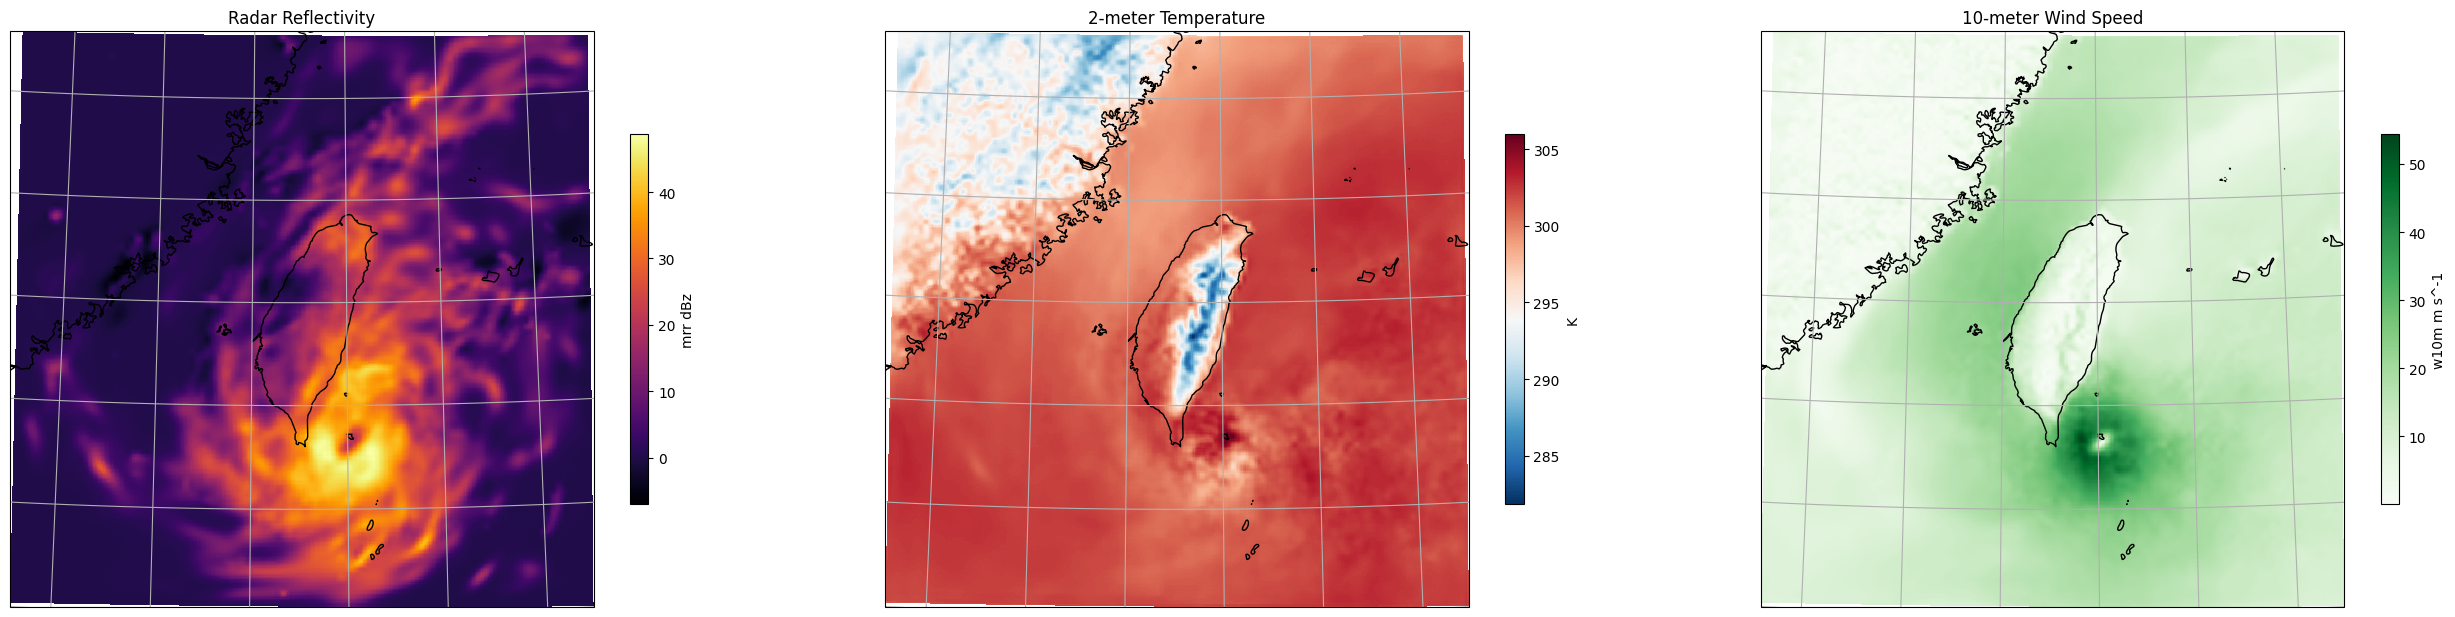

In [4]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

projection = ccrs.LambertConformal(
    central_longitude=io["lon"][:].mean(),
)

fig = plt.figure(figsize=(4 * 8, 8))

ax0 = fig.add_subplot(1, 3, 1, projection=projection)
c = ax0.pcolormesh(
    io["lon"],
    io["lat"],
    io["mrr"][0, 0],
    transform=ccrs.PlateCarree(),
    cmap="inferno",
)
plt.colorbar(c, ax=ax0, shrink=0.6, label="mrr dBz")
ax0.coastlines()
ax0.gridlines()
ax0.set_title("Radar Reflectivity")

ax1 = fig.add_subplot(1, 3, 2, projection=projection)
c = ax1.pcolormesh(
    io["lon"],
    io["lat"],
    io["t2m"][0, 0],
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
)
plt.colorbar(c, ax=ax1, shrink=0.6, label="K")
ax1.coastlines()
ax1.gridlines()
ax1.set_title("2-meter Temperature")

ax2 = fig.add_subplot(1, 3, 3, projection=projection)
c = ax2.pcolormesh(
    io["lon"],
    io["lat"],
    np.sqrt(io["u10m"][0, 0] ** 2 + io["v10m"][0, 0] ** 2),
    transform=ccrs.PlateCarree(),
    cmap="Greens",
)
plt.colorbar(c, ax=ax2, shrink=0.6, label="w10m m s^-1")
ax2.coastlines()
ax2.gridlines()
ax2.set_title("10-meter Wind Speed")

#plt.savefig("outputs/04_corr_diff_prediction.jpg")
